### Define the model architecture using a self-attention transformer
2. Deep Learning Models: VAE, Diffusion Model, Self-attention, and Transformer

### Import libraries


In [2]:
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from tqdm import tqdm
from torch import Tensor
import math
import matplotlib.pyplot as plt

### Define the model architecture using diffusion models

In [3]:
# Define the model architecture
class DiffusionModel(nn.Module):
    def __init__(self, num_channels=32, num_steps=10, input_dim=5, nhead=1, dropout=0.1, num_layers=4):
        super(DiffusionModel, self).__init__()
        self.num_channels = num_channels
        self.num_steps = num_steps
        self.net = nn.Sequential(
            nn.Linear(5, num_channels),
            nn.ReLU(),
            nn.Linear(num_channels, num_channels),
            nn.ReLU(),
            nn.Linear(num_channels, num_channels),
            nn.ReLU(),
            nn.Linear(num_channels, 5)
        )
        # self.net = nn.TransformerEncoder(
        #     nn.TransformerEncoderLayer(
        #         input_dim, 
        #         nhead=nhead, 
        #         dim_feedforward=input_dim, 
        #         dropout=dropout), 
        #     num_layers=num_layers)
    def forward(self, x, t):

        for i in range(self.num_steps):
            # Apply reverse diffusion step
            noise = torch.randn_like(x)
            noise = noise * (1 - (t / self.num_steps)).sqrt().unsqueeze(-1)
            y = x + noise
            x = self.net(y)
        return x

### Define the dataset and dataloader
- I use Dataset, Dataloader from torch.utils.data and build customize ColoredPiDataset, and normalize data points to [0, 1] or [-1, 1]:

In [4]:
class ColoredPiDataset(Dataset):
    def __init__(self, image_path, xs_path, ys_path):
        self.xs = np.load(xs_path)
        self.ys = np.load(ys_path)
        self.image_array = np.array(Image.open(image_path))
        self.rgb_values = self.image_array[self.xs, self.ys]
        
        # # Normalize xy values to be between 0 and 1
        self.xs, self.ys = self.xs / 299.0, self.ys / 299.0

        # # Normalize rgb values to be between 0 and 1
        self.rgb_values = self.rgb_values / 255.0

        # Normalize xy values to be between -1 and 1
        # self.xs, self.ys = (self.xs / 149.5) - 1.0, (self.ys / 149.5) - 1.0
        
        # # Normalize rgb values to be between -1 and 1
        # self.rgb_values = (self.rgb_values / 127.5) - 1.0

    def __len__(self):
        return len(self.xs)
        # return 30000

    def __getitem__(self, idx):
        if idx >= 5000:
            return torch.zeros((5)).to(torch.float32)
        return torch.tensor([self.xs[idx], self.ys[idx], self.rgb_values[idx][0], self.rgb_values[idx][1], self.rgb_values[idx][2]]).to(torch.float32)

### Define training function
- Then, I build training function to conduct back-propagation in each epoch. 

In [5]:
# Define training function
def train_diffusion(model, optimizer, criterion, dataloader, device):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        noise = torch.randn(batch.shape[0], 128).to(device)
        
        # # generate the timesteps_left schedule
        # timesteps_left = torch.linspace(0, 1, model.n_steps, device=device)
        # timesteps_left = timesteps_left.expand(batch_size, -1)
        # # generate the RGB values using the model
        # outputs = model(batch, timesteps_left)
        
        batch_t = np.random.randint(0, model.num_steps, size=batch_size)
        batch_t = np.sort(batch_t)[::-1] # Reverse order
        batch_t = torch.FloatTensor(batch_t / model.num_steps).to(device)
        outputs = model(batch, batch_t)

        loss = criterion(outputs, batch)

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

### Training
- Here I perform the training function and set the training parameters. I use tqdm to watch the training procedue.

Epoch [100/100], Train Loss: 0.0335: 100%|██████████| 100/100 [03:54<00:00,  2.35s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


xy mean: 145.4119522021367, xy std: 1.5967675153232117, xy max: 155.4961395263672, xy min: 138.85626220703125
rgb mean: 153.579857721288, rgb std: 16.50443804504499, rgb max: 187.2056427001953, rgb min: 134.9373016357422
Error: 11.300525925925927


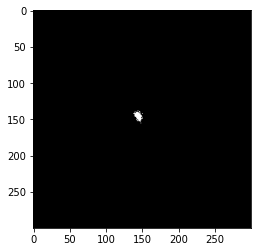

In [6]:
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters
input_dim = 5 # XYRGB values
output_dim = 5 # XYRGB values
hidden_dim = 128
latent_dim = 16
num_layers = 2
num_heads = 4
dropout = 0.1

batch_size = 32
learning_rate = 3e-4
num_epochs = 100
num_samples = 500

# Load the dataset
dataset = ColoredPiDataset('sparse_pi_colored.jpg', 'pi_xs.npy', 'pi_ys.npy')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize model, optimizer, and loss function
# model = DiffusionModel(n_steps=100, n_heads=4, n_dims=128, n_hidden=512, output_dim=output_dim, input_dim=input_dim).to(device)
model = DiffusionModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Train model
iteration = tqdm(range(num_epochs))
for epoch in iteration:
    train_loss = train_diffusion(model, optimizer, criterion, dataloader, device)
    iteration.set_description('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))
    
# Generate some samples from the model
generated_image = np.zeros(dataset.image_array.shape)

xy  = np.zeros((len(dataloader)*batch_size, 2))
rgb = np.zeros((len(dataloader)*batch_size, 3))
for sample_idx, batch in enumerate(dataloader):
    with torch.no_grad():
        samples = model.net(torch.randn(batch_size, 5).to(device))
        # samples = model.net(batch.to(device))

        # Denomarlizing samples
        # samples[:, :2] = (samples[:, :2] + 1) * 149.5
        samples[:, :2] = (samples[:, :2]) * 299
        
        # Denomarlizing samples
        # samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
        samples[:, 2:] = (samples[:, 2:]) * 255
        
        xy[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, :2].cpu().numpy()
        rgb[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, 2:].cpu().numpy()

        samples = samples.cpu().numpy().astype(np.uint8)
        for i in range(batch_size):
            x, y, r, g, b = samples[i]
            generated_image[x, y] = [r, g, b]
            
print(f'xy mean: {np.mean(xy)}, xy std: {np.std(xy)}, xy max: {np.max(xy)}, xy min: {np.min(xy)}')
print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}, rgb max: {np.max(rgb)}, rgb min: {np.min(rgb)}')
print(f'Error: {np.mean(np.abs(generated_image - dataset.image_array))}')

# Save the output image
# Image.fromarray(generated_image).save('generated_pi_colored.jpg')
plt.imshow(generated_image)

### Generate some samples from the model
- Finally, I performed the visualisation to see how the the distribution of model looks like by sampling the noise from gaussian distribution. I genrated the generated_image with the same shape of image_array. Also, I sample same number of points by iterating through the batchs in one epoch.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


xy mean: 145.42615888821774, xy std: 1.6382828443471118, xy max: 154.7888641357422, xy min: 138.25794982910156
rgb mean: 153.5719981224109, rgb std: 16.517482605117763, rgb max: 184.63394165039062, rgb min: 134.6112060546875
Error: 11.339525925925926


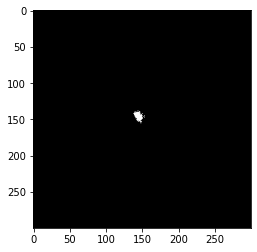

In [7]:
xy  = np.zeros((len(dataloader)*batch_size, 2))
rgb = np.zeros((len(dataloader)*batch_size, 3))
for sample_idx, batch in enumerate(dataloader):
    with torch.no_grad():
        # samples = model.net(torch.randn(batch_size, 5).to(device).unsqueeze(0)).squeeze(0)
        samples = model.net(torch.randn(batch_size, 5).to(device))
        # samples = model.net(batch.to(device).unsqueeze(0)).squeeze(0)
        # samples = model.net(batch.to(device))

        # Denomarlizing samples
        # samples[:, :2] = (samples[:, :2] + 1) * 149.5
        samples[:, :2] = (samples[:, :2]) * 299
        
        # Denomarlizing samples
        # samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
        samples[:, 2:] = (samples[:, 2:]) * 255
        
        xy[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, :2].cpu().numpy()
        rgb[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, 2:].cpu().numpy()

        samples = samples.cpu().numpy().astype(np.uint8)
        for i in range(batch_size):
            x, y, r, g, b = samples[i]
            generated_image[x, y] = [r, g, b]
            
print(f'xy mean: {np.mean(xy)}, xy std: {np.std(xy)}, xy max: {np.max(xy)}, xy min: {np.min(xy)}')
print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}, rgb max: {np.max(rgb)}, rgb min: {np.min(rgb)}')
print(f'Error: {np.mean(np.abs(generated_image - dataset.image_array))}')

# Save the output image
# Image.fromarray(generated_image).save('generated_pi_colored.jpg')
plt.imshow(generated_image)